In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from vitrocal.datasets import catalog
from vitrocal.preprocessors import StandardPreprocessor
from vitrocal.detectors import DerivativeDetector, StandardExtractor
from vitrocal.analyzers import StandardAnalyzer

Load data

In [100]:
datacatalog = catalog.DataCatalog()
df1 = datacatalog.load('e_green_dmso')
df2 = datacatalog.load('e_green')
df1.describe()

,1,2,3,4,5,6,7,8,9,10,...,63,64,65,66,67,68,69,70,71,72
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,...,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,2.885937,3.805275,0.350054,1.343267,1.007812,1.623404,4.233267,3.166713,2.013683,3.096746,...,1.411521,0.084604,4.723583,3.613958,1.191721,0.464929,1.810729,0.158633,5.252221,4.523425
std,1.569101,2.025602,0.594317,1.115353,1.172170,1.895488,3.411831,1.960805,1.154064,1.083802,...,1.093416,0.174733,2.229330,1.637982,0.633673,0.589033,2.529557,0.286108,4.344315,4.392315
min,1.248000,1.710000,0.000000,0.332000,0.194000,0.479000,1.699000,1.723000,0.773000,1.623000,...,0.353000,0.000000,2.503000,2.066000,0.331000,0.000000,0.178000,0.000000,1.766000,1.619000
25%,2.060000,2.753000,0.044000,0.599750,0.490500,0.819500,2.289250,2.254000,1.416000,2.370000,...,0.769500,0.000000,3.488250,2.653750,0.879000,0.155000,0.729000,0.000000,3.026250,2.309750
50%,2.325500,3.136000,0.119000,1.099000,0.714000,0.900000,2.877500,2.511500,1.774500,2.818500,...,0.997000,0.004000,4.054000,3.041000,1.025000,0.292000,0.902000,0.029000,3.407000,2.765000
75%,2.989500,3.965250,0.311000,1.489750,0.980000,1.305250,4.115000,3.116750,2.135750,3.580250,...,1.511750,0.085000,4.926750,3.745000,1.349000,0.461250,1.439250,0.172000,5.134250,3.968000
max,9.825000,14.107000,3.059000,6.785000,8.207000,8.888000,16.714000,16.834000,8.860000,7.259000,...,6.871000,1.317000,17.660000,12.010000,4.899000,3.292000,13.053000,1.759000,20.669000,22.657000


In [101]:
df2.describe()

,1,2,3,4,5,6,7,8,9,10,...,143,144,145,146,147,148,149,150,151,152
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,...,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,19.289658,12.060576,78.142595,18.341677,5.346563,9.499247,12.704709,13.530576,15.247968,31.709918,...,3.857582,17.209778,5.062405,17.357405,7.279943,1.885924,24.680095,39.355589,3.907639,7.814089
std,2.331940,1.271133,2.614166,1.891827,0.495620,1.791338,2.718708,1.014356,1.090410,3.594683,...,0.243295,1.464363,1.367093,2.054740,0.556735,0.319199,3.348789,5.275703,0.420110,0.544152
min,14.658000,9.703000,71.644000,14.498000,4.295000,7.097000,8.124000,10.625000,12.999000,24.870000,...,3.323000,13.702000,3.134000,13.246000,5.761000,1.162000,17.171000,28.864000,2.884000,6.388000
25%,17.307750,11.107750,76.395750,16.860000,5.005750,8.127000,10.710000,12.975500,14.357250,28.383000,...,3.681750,15.893500,4.114250,15.715500,6.982500,1.693000,22.550000,35.687250,3.627500,7.494000
50%,19.423500,11.977500,78.979000,18.189500,5.295500,9.003000,12.091500,13.554500,15.298500,32.220000,...,3.827500,17.206000,4.799500,17.319000,7.273000,1.856000,24.489500,39.274000,3.887000,7.796500
75%,21.369250,13.159000,80.165750,19.866250,5.656750,10.341000,14.204750,14.336000,16.169750,35.048250,...,3.999500,18.280750,5.733250,19.092500,7.639000,2.052000,27.091000,42.565250,4.135500,8.185500
max,23.217000,14.711000,82.163000,22.303000,6.510000,15.525000,20.742000,15.703000,17.203000,37.160000,...,4.438000,20.083000,9.835000,21.666000,8.853000,3.196000,31.799000,50.696000,4.998000,9.331000


Define model using default parameters

In [116]:
preprocessor = StandardPreprocessor(
    frames_per_second=1/2.5, 
    bleach_period=60,
    filter_frequency=.15, 
    baseline_threshold=10, 
    window_size=60)

extractor = StandardExtractor(
    window = (3, 30), # this is in seconds
    frames_per_second=1/2.5, 
    threshold=20)

analyzer = StandardAnalyzer(
    upper_decay_bound=.8,
    lower_decay_bound=.2
)

def pipeline(data, preprocessor, extractor, analyzer):
    d_f = preprocessor.preprocess(data)
    events = extractor.detect_and_extract(d_f)
    res, avg_res = analyzer.analyze(events)
    return d_f, events, res, avg_res

In [117]:
d_f_df1, events_df1, res_df1, avg_res_df1 = pipeline(df1, preprocessor, extractor, analyzer)
d_f_df2, events_df2, res_df2, avg_res_df2 = pipeline(df2, preprocessor, extractor, analyzer)

With FPS = 0.4, a window of (3, 30) seconds captures 1 frame(s) before and 12 frame(s) after each event.
With FPS = 0.4, a window of (3, 30) seconds captures 1 frame(s) before and 12 frame(s) after each event.


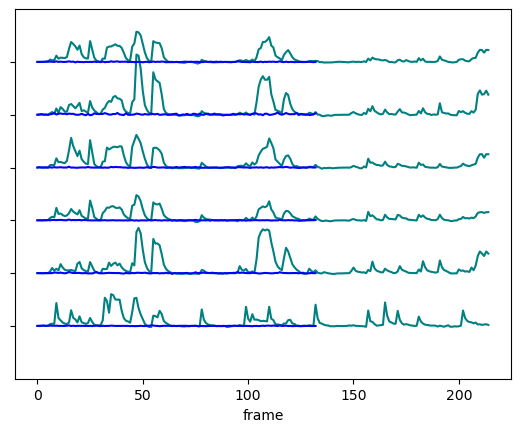

In [188]:
arbitrary_events = [1, 18, 26, 35, 41, 58]
e_dmso_green = d_f_df1.iloc[:, arbitrary_events]
e_green = d_f_df2.iloc[:, arbitrary_events]

def make_signal_plot(df1, df2, arbitrary_events, maxy=800, miny=0):

    n_events = len(arbitrary_events)
    n_samples = len(df1)
    dy = (maxy - miny) * 0.7

    fig, ax = plt.subplots()

    ax.set_ylim(-dy, n_events * dy)
    ax.set_yticks(np.arange(n_events) * dy, labels=[])
    ax.set_xlabel('frame')

    for i, (col1, col2) in enumerate(zip(df1, df2)):
        y1 = df1[col1] + i*dy
        y2 = df2[col2] + i*dy

        ax.plot(y1, color='teal', label='E DMSO Green')
        ax.plot(y2, color='blue', label= 'E Green')


make_signal_plot(e_dmso_green, e_green, arbitrary_events)
plt.savefig("../../data/04_reporting/data_compare.pdf", bbox_inches='tight')



In [157]:
len(e_dmso_green)

215

In [104]:
def plt_avg_detected(events, title=''):
    combined = pd.Series()
    for roi, values in events.items():
        for sequence in values:
            tmp = pd.Series(sequence)
            combined = pd.concat([combined, tmp], axis=1).agg("mean", axis=1)

    plt.plot(combined.sort_index())
    plt.title(title)

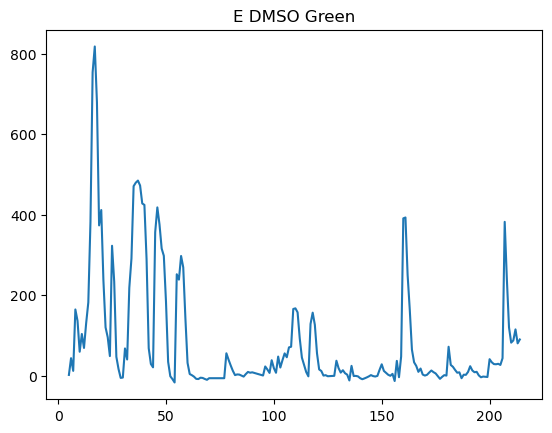

In [105]:
plt_avg_detected(events_df1, "E DMSO Green")

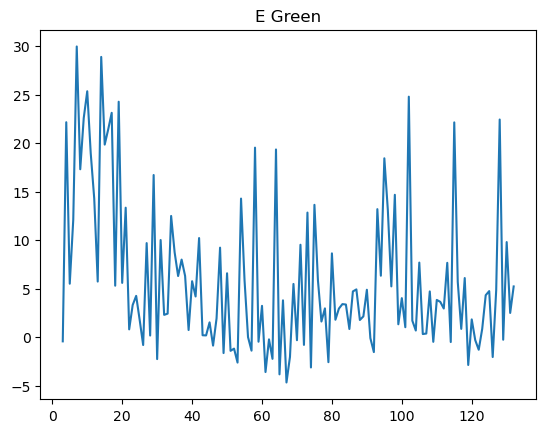

In [108]:
plt_avg_detected(events_df2, "E Green")
